In [1]:
!pip install -q tensorflow-addons==0.20.0
!pip install -q git+https://github.com/hoyso48/tf-utils@main
!pip install -q pyarrow leven

In [2]:
import gc
import json
import math
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

!pip install cached-property
from cached_property import cached_property
from shutil import copyfile

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
CONFIG = {"exp_name": 'test',
          "device": "GPU", # CPU, GPU, TPU-VM
          "max_len" : 128,
          "supplemental_size": 0.0,
          "batch_size": 32,
          "optimizer": 'ranger', # 'ranger', 'adam'
          "loss": 'ctc', # 'ctc', 'cce'
          "lr": 5e-4,
          "lr_min": 1e-6,
          "weight_decay": 0.05,
          "warmup": 0.025,
          "awp": True,
          "frame_len": 128}

root_save = '/kaggle/working/'
print(CONFIG["exp_name"])

test


In [4]:
df = pd.read_csv("/kaggle/input/asl-model/fold43-logs.csv")
df

,epoch,loss,val_loss
0,0,130.177216,62.087639
1,1,53.458683,37.169037
2,2,36.315758,28.873856
3,3,29.504580,24.514963
4,4,25.519331,21.281361
...,...,...,...
195,195,1.070783,32.422665
196,196,1.045717,32.495106
197,197,1.054323,32.592102
198,198,1.040213,32.585526


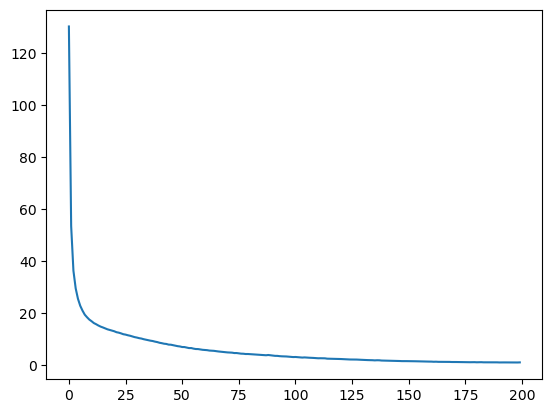

In [5]:
plt.plot(df['epoch'], df['loss'])

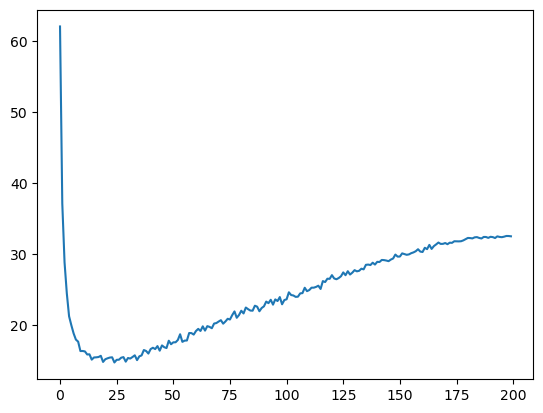

In [6]:
plt.plot(df['epoch'], df['val_loss'])

In [7]:
copyfile(src = "/kaggle/input/ctc-tpu/CTC_TPU.py", dst = "/kaggle/working/CTC_TPU.py")

# import all our functions
from CTC_TPU import classic_ctc_loss

In [8]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

pad_token = '^'
pad_token_idx = 59

char_to_num[pad_token] = pad_token_idx

num_to_char = {j:i for i,j in char_to_num.items()}
df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')

LIP = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE] + [f'x_face_{i}' for i in LIP]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE] + [f'y_face_{i}' for i in LIP]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE] + [f'z_face_{i}' for i in LIP]

SEL_COLS = X + Y + Z
FRAME_LEN = 128
MAX_PHRASE_LENGTH = 64

LIP_IDX_X   = [i for i, col in enumerate(SEL_COLS)  if  "face" in col and "x" in col]
RHAND_IDX_X = [i for i, col in enumerate(SEL_COLS)  if "right" in col and "x" in col]
LHAND_IDX_X = [i for i, col in enumerate(SEL_COLS)  if  "left" in col and "x" in col]
RPOSE_IDX_X = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE and "x" in col]
LPOSE_IDX_X = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE and "x" in col]

LIP_IDX_Y   = [i for i, col in enumerate(SEL_COLS)  if  "face" in col and "y" in col]
RHAND_IDX_Y = [i for i, col in enumerate(SEL_COLS)  if "right" in col and "y" in col]
LHAND_IDX_Y = [i for i, col in enumerate(SEL_COLS)  if  "left" in col and "y" in col]
RPOSE_IDX_Y = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE and "y" in col]
LPOSE_IDX_Y = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE and "y" in col]

LIP_IDX_Z   = [i for i, col in enumerate(SEL_COLS)  if  "face" in col and "z" in col]
RHAND_IDX_Z = [i for i, col in enumerate(SEL_COLS)  if "right" in col and "z" in col]
LHAND_IDX_Z = [i for i, col in enumerate(SEL_COLS)  if  "left" in col and "z" in col]
RPOSE_IDX_Z = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE and "z" in col]
LPOSE_IDX_Z = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE and "z" in col]

RHM = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/rh_mean.npy")
LHM = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lh_mean.npy")
RPM = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/rp_mean.npy")
LPM = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lp_mean.npy")
LIPM = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lip_mean.npy")

RHS = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/rh_std.npy")
LHS = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lh_std.npy")
RPS = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/rp_std.npy")
LPS = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lp_std.npy")
LIPS = np.load("/kaggle/input/aslfr-dataset-tfrecords/mean_std/lip_std.npy")

@tf.function()
def resize_pad(x):
    if tf.shape(x)[0] < CONFIG["frame_len"]:
        x = tf.pad(x, ([[0, CONFIG["frame_len"]-tf.shape(x)[0]], [0, 0], [0, 0]]), constant_values=float("NaN"))
    else:
        x = tf.image.resize(x, (CONFIG["frame_len"], tf.shape(x)[1]))
    return x

@tf.function()
def get_time_lag(x):
    length, feature = tf.shape(x)[0], tf.shape(x)[1]
    
    if tf.rank(x) == 3: # (frame_len, features, 3)
        x = x[None,...]
    
    x = x[...,:2] # ony get x, y coordinate
    dx = tf.cond(tf.shape(x)[1]>1, lambda: tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]), lambda:tf.zeros_like(x))
    dx2 = tf.cond(tf.shape(x)[1]>1, lambda: tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]), lambda:tf.zeros_like(x))
    x = tf.concat([
                tf.reshape(x, (length, 2*feature)),
                tf.reshape(dx, (length, 2*feature)),
                tf.reshape(dx2, (length, 2*feature)),
            ], axis = -1)
    return x

@tf.function(jit_compile=True)
def pre_process0(x):
    lip_x = tf.gather(x, LIP_IDX_X, axis=1)
    lip_y = tf.gather(x, LIP_IDX_Y, axis=1)
    lip_z = tf.gather(x, LIP_IDX_Z, axis=1)
    
#     nose_x = tf.gather(x, NOSE_IDX_X, axis=1)
#     nose_y = tf.gather(x, NOSE_IDX_Y, axis=1)
#     nose_z = tf.gather(x, NOSE_IDX_Z, axis=1)
    
#     leye_x = tf.gather(x, LEYE_IDX_X, axis=1)
#     leye_y = tf.gather(x, LEYE_IDX_Y, axis=1)
#     leye_z = tf.gather(x, LEYE_IDX_Z, axis=1)
    
#     reye_x = tf.gather(x, REYE_IDX_X, axis=1)
#     reye_y = tf.gather(x, REYE_IDX_Y, axis=1)
#     reye_z = tf.gather(x, REYE_IDX_Z, axis=1)
    
    rhand_x = tf.gather(x, RHAND_IDX_X, axis=1)
    rhand_y = tf.gather(x, RHAND_IDX_Y, axis=1)
    rhand_z = tf.gather(x, RHAND_IDX_Z, axis=1)
    
    lhand_x = tf.gather(x, LHAND_IDX_X, axis=1)
    lhand_y = tf.gather(x, LHAND_IDX_Y, axis=1)
    lhand_z = tf.gather(x, LHAND_IDX_Z, axis=1)

    rpose_x = tf.gather(x, RPOSE_IDX_X, axis=1)
    rpose_y = tf.gather(x, RPOSE_IDX_Y, axis=1)
    rpose_z = tf.gather(x, RPOSE_IDX_Z, axis=1)
    
    lpose_x = tf.gather(x, LPOSE_IDX_X, axis=1)
    lpose_y = tf.gather(x, LPOSE_IDX_Y, axis=1)
    lpose_z = tf.gather(x, LPOSE_IDX_Z, axis=1)
    
    lip   = tf.concat([lip_x[..., tf.newaxis], lip_y[..., tf.newaxis], lip_z[..., tf.newaxis]], axis=-1)
#     nose  = tf.concat([nose_x[..., tf.newaxis], nose_y[..., tf.newaxis], nose_z[..., tf.newaxis]], axis=-1)
#     leye  = tf.concat([leye_x[..., tf.newaxis], leye_y[..., tf.newaxis], leye_z[..., tf.newaxis]], axis=-1)
#     reye  = tf.concat([reye_x[..., tf.newaxis], reye_y[..., tf.newaxis], reye_z[..., tf.newaxis]], axis=-1)
    rhand = tf.concat([rhand_x[..., tf.newaxis], rhand_y[..., tf.newaxis], rhand_z[..., tf.newaxis]], axis=-1)
    lhand = tf.concat([lhand_x[..., tf.newaxis], lhand_y[..., tf.newaxis], lhand_z[..., tf.newaxis]], axis=-1)
    rpose = tf.concat([rpose_x[..., tf.newaxis], rpose_y[..., tf.newaxis], rpose_z[..., tf.newaxis]], axis=-1)
    lpose = tf.concat([lpose_x[..., tf.newaxis], lpose_y[..., tf.newaxis], lpose_z[..., tf.newaxis]], axis=-1)
    
    hand = tf.concat([rhand, lhand], axis=1)
    hand = tf.where(tf.math.is_nan(hand), 0.0, hand)
    mask = tf.math.not_equal(tf.reduce_sum(hand, axis=[1, 2]), 0.0)

    lip = lip[mask]
#     nose = nose[mask]
#     leye = leye[mask]
#     reye = reye[mask]
    rhand = rhand[mask]
    lhand = lhand[mask]
    rpose = rpose[mask]
    lpose = lpose[mask]

    return lip, rhand, lhand, rpose, lpose

@tf.function()
def pre_process1(lip, rhand, lhand, rpose, lpose):
    lip   = (resize_pad(lip) - LIPM) / LIPS
#     nose  = (resize_pad(nose) - NOSEM) / NOSES
#     leye  = (resize_pad(leye) - LEYEM) / LEYES
#     reye  = (resize_pad(reye) - REYEM) / REYES
    rhand = (resize_pad(rhand) - RHM) / RHS
    lhand = (resize_pad(lhand) - LHM) / LHS
#     rpose = (resize_pad(rpose) - RPM) / RPS
#     lpose = (resize_pad(lpose) - LPM) / LPS
    
    x = tf.concat([lip, rhand, lhand], axis=1)
#     s = tf.shape(x)
#     x = tf.reshape(x, (s[0], s[1]*s[2]))
    x = get_time_lag(x)
    x = tf.where(tf.math.is_nan(x), 0.0, x)
    return x

#This fail on TPU
'''
pre0 = pre_process0(frames)
pre1 = pre_process1(*pre0)
INPUT_SHAPE = list(pre1.shape)
print(INPUT_SHAPE)
pre1
'''
INPUT_SHAPE = [128, 368]
@tf.function()
def decode_phrase(pred):
    x = tf.argmax(pred, axis=1)
    diff = tf.not_equal(x[:-1], x[1:])
    adjacent_indices = tf.where(diff)[:, 0]
    x = tf.gather(x, adjacent_indices)
    mask = x != pad_token_idx
    x = tf.boolean_mask(x, mask, axis=0)
    return x

INPUT_SHAPE = [128, 492]

In [9]:
def CTCLoss(labels, logits):
    label_length = tf.reduce_sum(tf.cast(labels != pad_token_idx, tf.int32), axis=-1)
    logit_length = tf.ones(tf.shape(logits)[0], dtype=tf.int32) * tf.shape(logits)[1]
    
    loss = classic_ctc_loss(
            labels=labels,
            logits=logits,
            label_length=label_length,
            logit_length=logit_length,
            blank_index=pad_token_idx,
        )
    loss = tf.reduce_mean(loss)
    return loss

In [10]:
#Copied from previous comp 1st place model: https://www.kaggle.com/code/hoyso48/1st-place-solution-training
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn
    
class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)
      
    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
          self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x


def TransformerBlock(dim=256, num_heads=8, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

In [11]:
def get_model(dim = 384, dropout_step=15):
    inp = tf.keras.Input(INPUT_SHAPE)
    x = inp
    ksize = 11
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.AveragePooling1D(2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
#     x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(len(char_to_num))(x)

    model = tf.keras.Model(inp, x)
    return model

In [12]:
model = get_model()
model.load_weights("/kaggle/input/asl-model/fold43-bestscore.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 492)]   0           []                               
                                                                                                  
 stem_conv (Dense)              (None, 128, 384)     188928      ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 384)     1536        ['stem_conv[0][0]']              
                                                                                                  
 1_expand_conv (Dense)          (None, 128, 768)     295680      ['stem_bn[0][0]']                
                                                                                              

In [13]:
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(SEL_COLS)], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(SEL_COLS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process0(x)
        x = pre_process1(*x)
        x = tf.reshape(x, INPUT_SHAPE)
        x = x[None]
        x = self.model(x, training=False)
        x = x[0]
        x = decode_phrase(x)
        x = tf.cond(tf.shape(x)[0] == 0, lambda: tf.zeros(1, tf.int64), lambda: tf.identity(x))
        x = tf.one_hot(x, 59)
        return {'outputs': x}

tflitemodel_base = TFLiteModel(model)

In [14]:
def load_relevant_data_subset(pq_path):
    return pd.read_parquet(pq_path, columns=SEL_COLS)

file_id = df.file_id.iloc[0]
inpdir = "/kaggle/input/asl-fingerspelling/train_landmarks"
pqfile = f"{inpdir}/{file_id}.parquet"
seq_refs = df.loc[df.file_id == file_id]
seqs = load_relevant_data_subset(pqfile)

seq_id = seq_refs.sequence_id.iloc[0]
frames = seqs.iloc[seqs.index == seq_id]
phrase = str(df.loc[df.sequence_id == seq_id].phrase.iloc[0])

y_test = tflitemodel_base(frames)["outputs"]
print(y_test.shape)

(13, 59)


In [15]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
keras_model_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = keras_model_converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
    
with open('inference_args.json', "w") as f:
    json.dump({"selected_columns" : SEL_COLS}, f)
    
!zip submission.zip './model.tflite' './inference_args.json'

  adding: model.tflite (deflated 19%)
  adding: inference_args.json (deflated 83%)
